<a href="https://colab.research.google.com/github/Davi-SC/reconhecimento-facial/blob/main/reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando dependências

In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Clonando e configurando o Darknet para YOLOv4

In [2]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15903, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15903 (delta 0), reused 1 (delta 0), pack-reused 15900 (from 1)
Receiving objects: 100% (15903/15903), 14.43 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (10708/10708), done.


Configurando o makefile para utilizar GPU, OPENCV e LIBSO

In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
!make  #Construindo o darknet com as configurações feitas

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:

Baixando o arquivo de pesos do Yolov4 pré-treinado para detectar 80 classes

In [5]:
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights

--2025-08-06 18:41:30--  https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/75388965/749e43d0-8605-436f-b26c-12ee01c2a265?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-06T19%3A33%3A39Z&rscd=attachment%3B+filename%3Dyolov4.weights&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-06T18%3A33%3A10Z&ske=2025-08-06T19%3A33%3A39Z&sks=b&skv=2018-11-09&sig=raZU9LXqOPToByH4wxg2ihKjNd7noyVFhYqmvZoUrqk%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NDUwNTk5MCwibmJmIjoxNzU0NTA1NjkwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNv

## Darknet para Python
Importando algumas funções do darknet.py para nosso espaço de trabalho


In [6]:
from darknet import *
# Carregar em nossa rede de arquitetura Yolov4
cfg_file = "cfg/yolov4.cfg"
weights_file = "yolov4.weights"
data_file = "cfg/coco.data"
weights_file = "yolov4.weights" # Changed from yolov4-csp.weights
print(f"Loading network with config: {cfg_file}, data: {data_file}, weights: {weights_file}")
network, class_names, class_colors = load_network(cfg_file, data_file, weights_file)
width = network_width(network)
height = network_height(network)
print(f"Network loaded with dimensions: {width}x{height}")


# função auxiliar do DarkNet para executar a detecção na imagem
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # obtendo bordas da imagem para converter em bounding boxes de tamanho certo
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # executando o modelo DarkNet para obter detecções
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # Lower the confidence threshold to see if detections appear
  detections = detect_image(network, class_names, darknet_image, thresh=.1) # Reduced threshold
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

Loading network with config: cfg/yolov4.cfg, data: cfg/coco.data, weights: yolov4.weights
Network loaded with dimensions: 608x608


## Funções auxiliares


In [7]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Darknet helper function to convert bounding boxes to points
def bbox2points(bbox):
  x, y, w, h = bbox
  xmin = int(round(x - (w / 2)))
  xmax = int(round(x + (w / 2)))
  ymin = int(round(y - (h / 2)))
  ymax = int(round(y + (h / 2)))
  return xmin, ymin, xmax, ymax

## Testando YOLOv4

Vamos testar o YOLOv4 com uma imagem de teste

Processing image with shape: (424, 640, 3) and dtype: uint8
Number of detections: 3
Detection: Label=horse, Confidence=98.37, Bbox=[406, 140, 601, 344]
Detection: Label=dog, Confidence=99.45, Bbox=[62, 265, 204, 345]
Detection: Label=person, Confidence=99.79, Bbox=[193, 98, 272, 378]


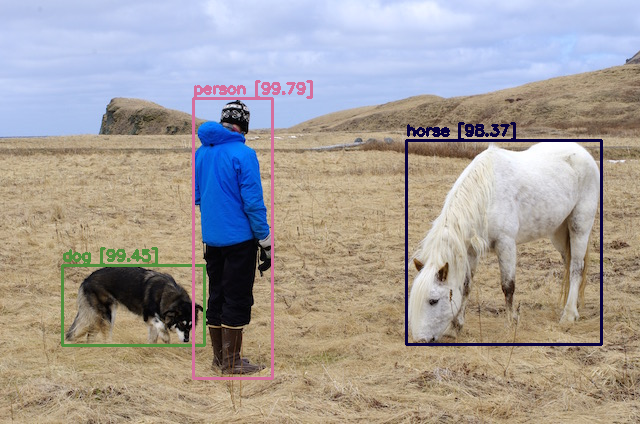

In [8]:
image = cv2.imread("data/person.jpg")
print(f"Processing image with shape: {image.shape} and dtype: {image.dtype}")
# Display the original image before processing

detections, width_ratio, height_ratio = darknet_helper(image, width, height)

# Add print statement to check if detections are found
print(f"Number of detections: {len(detections)}")

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # Add print statement to check bounding box coordinates
  print(f"Detection: Label={label}, Confidence={float(confidence):.2f}, Bbox=[{left}, {top}, {right}, {bottom}]") # Convert confidence to float
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Configurando o YOLOv4 para imagens da webcam

In [9]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


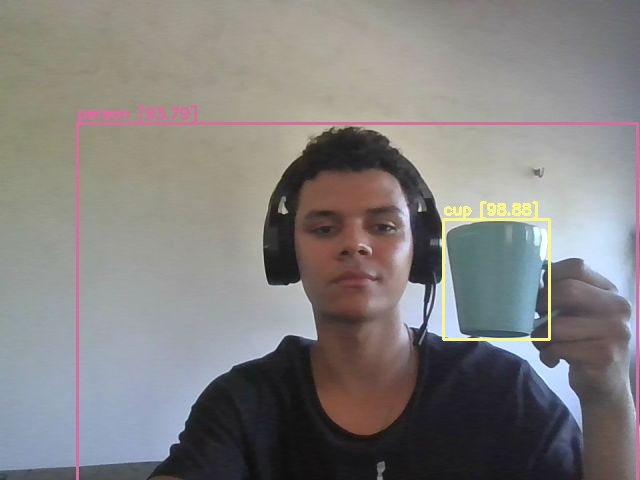

In [11]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

## Configurando YOLOv4 para videos da webcam

In [14]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Executando com video da webcam

In [17]:
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0
# Add a small delay to allow the webcam stream to initialize
time.sleep(2)
while True:
    js_reply = video_frame(label_html, bbox)
    # Check if js_reply is not empty before processing
    if not js_reply or "img" not in js_reply:
        break

    frame = js_to_image(js_reply["img"])
    # print(f"Processing video frame with shape: {frame.shape} and dtype: {frame.dtype}")


    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)


    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      # Add print statement to check bounding box coordinates
      # print(f"Detection: Label={label}, Confidence={float(confidence):.2f}, Bbox=[{left}, {top}, {right}, {bottom}]") # Convert confidence to float
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

/tmp/ipython-input-2122620022.py:23: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
